In [1]:
#########################################################
####
#### Tutorial: RNA Design with Infrared (for Developers)
####
#########################################################

###############################################
## Start with simple sampling of RNA sequences

# -- _the_ main module of Infrared
import infrared as ir

In [2]:
# -- specify a constraint network and it's tree decomp

# our first CN is _very_ simple: 20 variables (=sequence positions), no dependencies
cn = ir.ConstraintNetwork(varnum=20, domains=4)
# produce cluster tree for the CN, using default tree decomposition
ct = ir.ClusterTree(cn)

tree width = 0
bags = [[10], [3], [6], [9], [8], [16], [13], [11], [1], [14], [19], [2], [17], [4], [5], [7], [0], [18], [12], [15]]
edges = [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 9), (0, 10), (0, 11), (0, 12), (0, 13), (0, 14), (0, 15), (0, 16), (0, 17), (0, 18), (0, 19)]


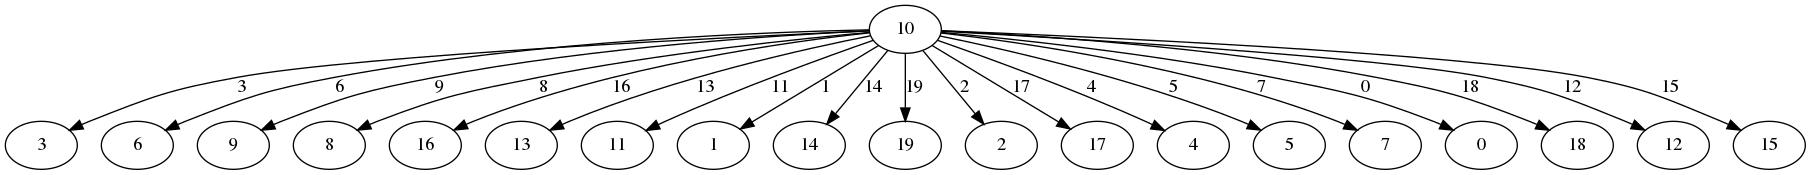

In [3]:
def show_td_info(ct,width):
    td = ct.get_td()
    print("tree width =", td.treewidth())
    print("bags =", td.get_bags())
    print("edges =", td.get_edges())
    
    tmpfile="tmp_out"
    td.writeTD(open(tmpfile+".dot","w"))
    import treedecomp
    treedecomp.dotfile_to_png(tmpfile+".dot")
    from IPython.display import Image
    return Image(filename=(tmpfile+".png"),width=width)
    
show_td_info(ct,500)

In [4]:
# -- evaluate the cluster tree
#   -- in this simple case, this will count the structures
count = ct.evaluate()
print("# =",int(count))
# btw, of course, 'count' is the number of all possible seqs 4**20

# = 1099511627776


In [5]:
# -- generate 10 samples
samples = [ct.sample().values() for i in range(10)]

In [6]:
samples

[[3, 0, 2, 0, 2, 2, 3, 3, 0, 0, 1, 3, 1, 0, 0, 2, 1, 0, 2, 0],
 [2, 1, 3, 3, 3, 1, 0, 2, 3, 3, 2, 3, 2, 1, 3, 3, 1, 1, 1, 2],
 [3, 3, 0, 2, 0, 0, 2, 1, 1, 3, 2, 3, 0, 1, 3, 0, 2, 1, 2, 0],
 [3, 1, 1, 2, 2, 1, 1, 2, 0, 3, 2, 3, 1, 3, 0, 0, 1, 2, 3, 2],
 [1, 3, 3, 1, 3, 1, 2, 3, 2, 1, 3, 3, 2, 0, 0, 2, 3, 2, 3, 1],
 [0, 1, 3, 1, 1, 2, 2, 1, 2, 1, 3, 3, 1, 3, 0, 1, 3, 0, 0, 0],
 [0, 0, 2, 3, 3, 0, 2, 2, 3, 2, 1, 2, 2, 0, 3, 0, 0, 0, 0, 0],
 [2, 0, 3, 0, 0, 0, 3, 0, 3, 0, 2, 0, 0, 3, 3, 3, 0, 1, 0, 2],
 [2, 2, 3, 3, 1, 0, 1, 0, 2, 3, 3, 1, 0, 2, 2, 0, 0, 3, 3, 1],
 [0, 3, 3, 0, 3, 3, 3, 2, 0, 3, 2, 3, 2, 2, 2, 3, 1, 3, 2, 3]]

In [7]:
# -- and show them (pretty)
from infrared import rna
[rna.values_to_sequence(s) for s in samples]

['UAGAGGUUAACUCAAGCAGA',
 'GCUUUCAGUUGUGCUUCCCG',
 'UUAGAAGCCUGUACUAGCGA',
 'UCCGGCCGAUGUCUAACGUG',
 'CUUCUCGUGCUUGAAGUGUC',
 'ACUCCGGCGCUUCUACUAAA',
 'AAGUUAGGUGCGGAUAAAAA',
 'GAUAAAUAUAGAAUUUACAG',
 'GGUUCACAGUUCAGGAAUUC',
 'AUUAUUUGAUGUGGGUCUGU']

In [8]:
##################################################
## add constraints from an RNA secondary structure
structure = "((((...))))(((...)))"
bps = rna.parseRNAStructureBps(structure)

In [9]:
bps

[(0, 10), (1, 9), (2, 8), (3, 7), (11, 19), (12, 18), (13, 17)]

In [10]:
complementary_nucleotides = ["AU","CG","GC","GU","UA","UG"]
# -- define complementarity constraints
ir.def_constraint_class( 
    'ComplConstraint',
    lambda i,j: [i,j],
    lambda x,y: rna.values_to_sequence([x,y]) 
                  in complementary_nucleotides
)    
    
## btw, there is already a pre-defined constraint rna.ComplConstraint,
## which we could have used as well

cons = [ ComplConstraint( i = i, j = j ) for (i,j) in bps ]
deps = [ x.vars() for x in cons ]

cons, deps

([<infrared.infrared.ComplConstraint at 0x7f6e729f9b80>,
 [[0, 10], [1, 9], [2, 8], [3, 7], [11, 19], [12, 18], [13, 17]])

tree width = 1
bags = [[19, 11], [10], [10, 0], [1], [1, 9], [17], [17, 13], [18], [18, 12], [7], [3, 7], [8], [8, 2], [14], [16], [4], [5], [15], [6]]
edges = [(0, 1), (0, 3), (0, 5), (0, 7), (0, 9), (0, 11), (0, 13), (0, 14), (0, 15), (0, 16), (0, 17), (0, 18), (1, 2), (3, 4), (5, 6), (7, 8), (9, 10), (11, 12)]


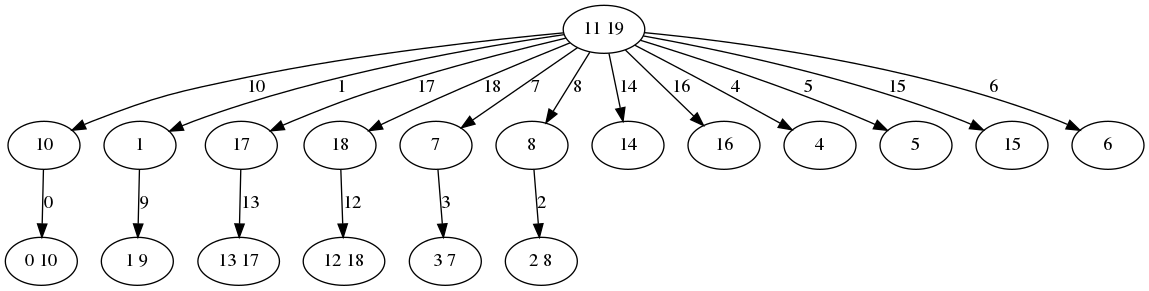

In [23]:
# -- reinitialize constraint network, rebuild tree decomp and cluster tree
#complementary_nucleotides = ["AU"]

seqlen = len(structure) # --> number of positions / variables in the CN
cn = ir.ConstraintNetwork(varnum=seqlen, domains=4, constraints = cons)
ct = ir.ClusterTree(cn)

show_td_info(ct,500)

In [12]:
# generate samples (with complementarity constraints)
def spit_them_samples_out(ct,num, seqlen=None):
    samples = [ ct.sample().values() for i in range(num) ]
    if seqlen is not None:
        return [ rna.values_to_sequence(s[:seqlen])+''.join(map(str,s[seqlen:]))  for s in samples ]
    else:
        return [ rna.values_to_sequence(s)  for s in samples ]

count = ct.evaluate()
print("# =",int(count))
# btw, count == 6**7 * 4**6, by simple combinatorics

print("  "+structure)
spit_them_samples_out(ct,10)

# = 1146617856
  ((((...))))(((...)))


['GGGUCGAACUUCUAAGCUGG',
 'UGUGACUCAUAGAGCUCCUU',
 'CGCUGGGGGCGGGAGCAUCU',
 'UUUUGAGAAGAGGCACGGCC',
 'UUUGCUUCGGGUGUGAGACG',
 'UGCGUCACGUGGACUCCGUC',
 'CGUGUAAUACGGCACCUUGU',
 'GGGUUCCGUUCGCGCACCGC',
 'AUAUUACAUAUGUUCGGAAU',
 'GGCAAGUUGCUAAUACUAUU']

In [13]:
##########################
## Control the GC content

# -- define function for GC Control
ir.def_function_class(
    'GCControl',
    lambda i: [i],
    lambda x: rna.value_to_nucleotide( x ) in "GC"
)

## btw, there is predefined rna.GCControl

In [14]:
## -- setup functions
gc_weight = 1 ## <- try different weights: 0.1, 10, ...

gc_funs = [ GCControl( i = i, weight = gc_weight )
              for i in range( seqlen ) ]

# -- reinitialize constraint network, rebuild tree decomp and cluster tree
cn = ir.ConstraintNetwork( varnum = seqlen, domains = 4,
                           constraints = cons,
                           functions = gc_funs )
ct = ir.ClusterTree( cn )

spit_them_samples_out( ct, 10 )

['CACAGGCUGUGGAUGGCAUU',
 'GGUUACCGGCCCCGUCUCGG',
 'GCUCUGCGAGUAAAGACUUU',
 'GUCCUGGGGGUGGGGUCUUU',
 'AUACAAGGUGUCAGGAGUUG',
 'GGGAAUUUUCUUCUAGGGGG',
 'CAGGUGGUUUGGGCUUGGCU',
 'GGGUUUCGUUCGCUUGGAGC',
 'GCGCUACGUGCUGACGAUUG',
 'GUGAGGGUUGUUAGAAUCUG']

In [15]:
##########################
## Control the BP energy

rna.set_bpenergy_table() # set bp energies to magic numbers

bpe_weight = 2 ## <- try different weights: 0.1, 10, ...
bpe_funs = [ rna.BPEnergy( bpe_weight, i=i, j=j, is_terminal=False ) for (i,j) in bps ] 

cn = ir.ConstraintNetwork(varnum=seqlen, domains=4,
                          constraints=cons,
                          functions=bpe_funs + gc_funs)
ct = ir.ClusterTree(cn)


print("  "+structure)
spit_them_samples_out(ct, 10)

  ((((...))))(((...)))


['UGGUUCUACUGCCGCAUCGG',
 'CCAGAGACUGGACCUGUGGU',
 'AGCUUUAAGCUGGGUUGUCC',
 'CCCGUUUCGGGCAGGGACUG',
 'GGCUAGCGGCCGUGAGUCGC',
 'UUGGAACUCGGGAGGGGCUC',
 'UCUUAAAAGGACGUAAGACG',
 'GCCUGUAAGGCGCCGGUGGC',
 'GGGGCCCCCCCCAGUAGUUG',
 'GCCAGUGUGGCGGUUUGAUC']

In [16]:
### as example of additional hard constraints: avoid GG dinucleotides

ir.def_constraint_class('AvoidGGConstraint',
                         lambda i: [i, i+1],
                         lambda x,y: rna.values_to_sequence([x,y]) != "GG")

gg_cons = [ AvoidGGConstraint(i=i) for i in range(seqlen-1) ]

In [17]:
cn = ir.ConstraintNetwork(varnum=seqlen, domains=4,
                          constraints = cons + gg_cons,
                          functions = bpe_funs + gc_funs)
ct = ir.ClusterTree(cn)

print("  "+structure)
spit_them_samples_out(ct, 10)

  ((((...))))(((...)))


['CGUCCACGACGUAGUAGUUA',
 'GUGUUAAAUACACUUAUAGU',
 'UCGCUGUGCGACUUGAUGAG',
 'GCUCUGCGAGCCGUUCAACG',
 'GUAUGAGAUACAGUGCUGCU',
 'GUGUAGUGCACUGUCGCGUG',
 'GUCGAUCUGAUGUACACUAC',
 'AUACCACGUGUCGCUGUGCG',
 'UCGUAACGCGACUCUAAGAG',
 'CGCGAGCUGCGAGUACCAUU']

  ((((...))))(((...)))
tree width = 7
bags = [[25, 44, 3, 49, 7, 23, 28, 4], [3, 44, 49, 7, 23, 2, 28], [44, 49, 7, 23, 2, 0, 28], [2, 1, 44, 49, 7, 23, 0, 28], [46, 25, 3, 44, 49, 7, 28, 4], [49, 7, 2, 0, 28, 8, 1], [46, 49, 5, 7, 28, 25, 4], [46, 49, 5, 7, 28, 25, 6], [46, 49, 5, 7, 48, 6], [26, 5, 7, 28, 25, 6], [49, 0, 8, 28, 1, 9], [49, 0, 8, 28, 9, 10], [49, 31, 28, 8, 9, 10], [49, 31, 52, 8, 9, 10], [11, 31, 52, 10], [11, 31, 52, 32], [11, 32, 52, 12], [11, 54, 52, 32, 12], [11, 54, 32, 12, 13], [11, 54, 32, 12, 13, 34], [11, 54, 37, 12, 13, 34], [11, 54, 37, 12, 13, 58, 34], [54, 17, 12, 13, 58, 11, 37, 34], [54, 55, 17, 37, 13, 58, 34], [55, 14, 17, 37, 13, 58, 34], [55, 16, 17, 37, 14, 58, 34], [55, 16, 37, 15, 14, 58, 34], [55, 16, 15, 57, 14, 58], [16, 14, 37, 15, 36, 34], [31, 8, 28, 29, 9, 10], [49, 52, 51, 8, 9, 10], [11, 18, 17, 12, 37, 58], [11, 19, 17, 37, 18, 58], [3, 44, 46, 45, 4], [46, 5, 48, 47, 6], [33, 32, 12, 13, 34], [3, 23, 24, 25, 4], [30, 31, 29, 9, 10], [

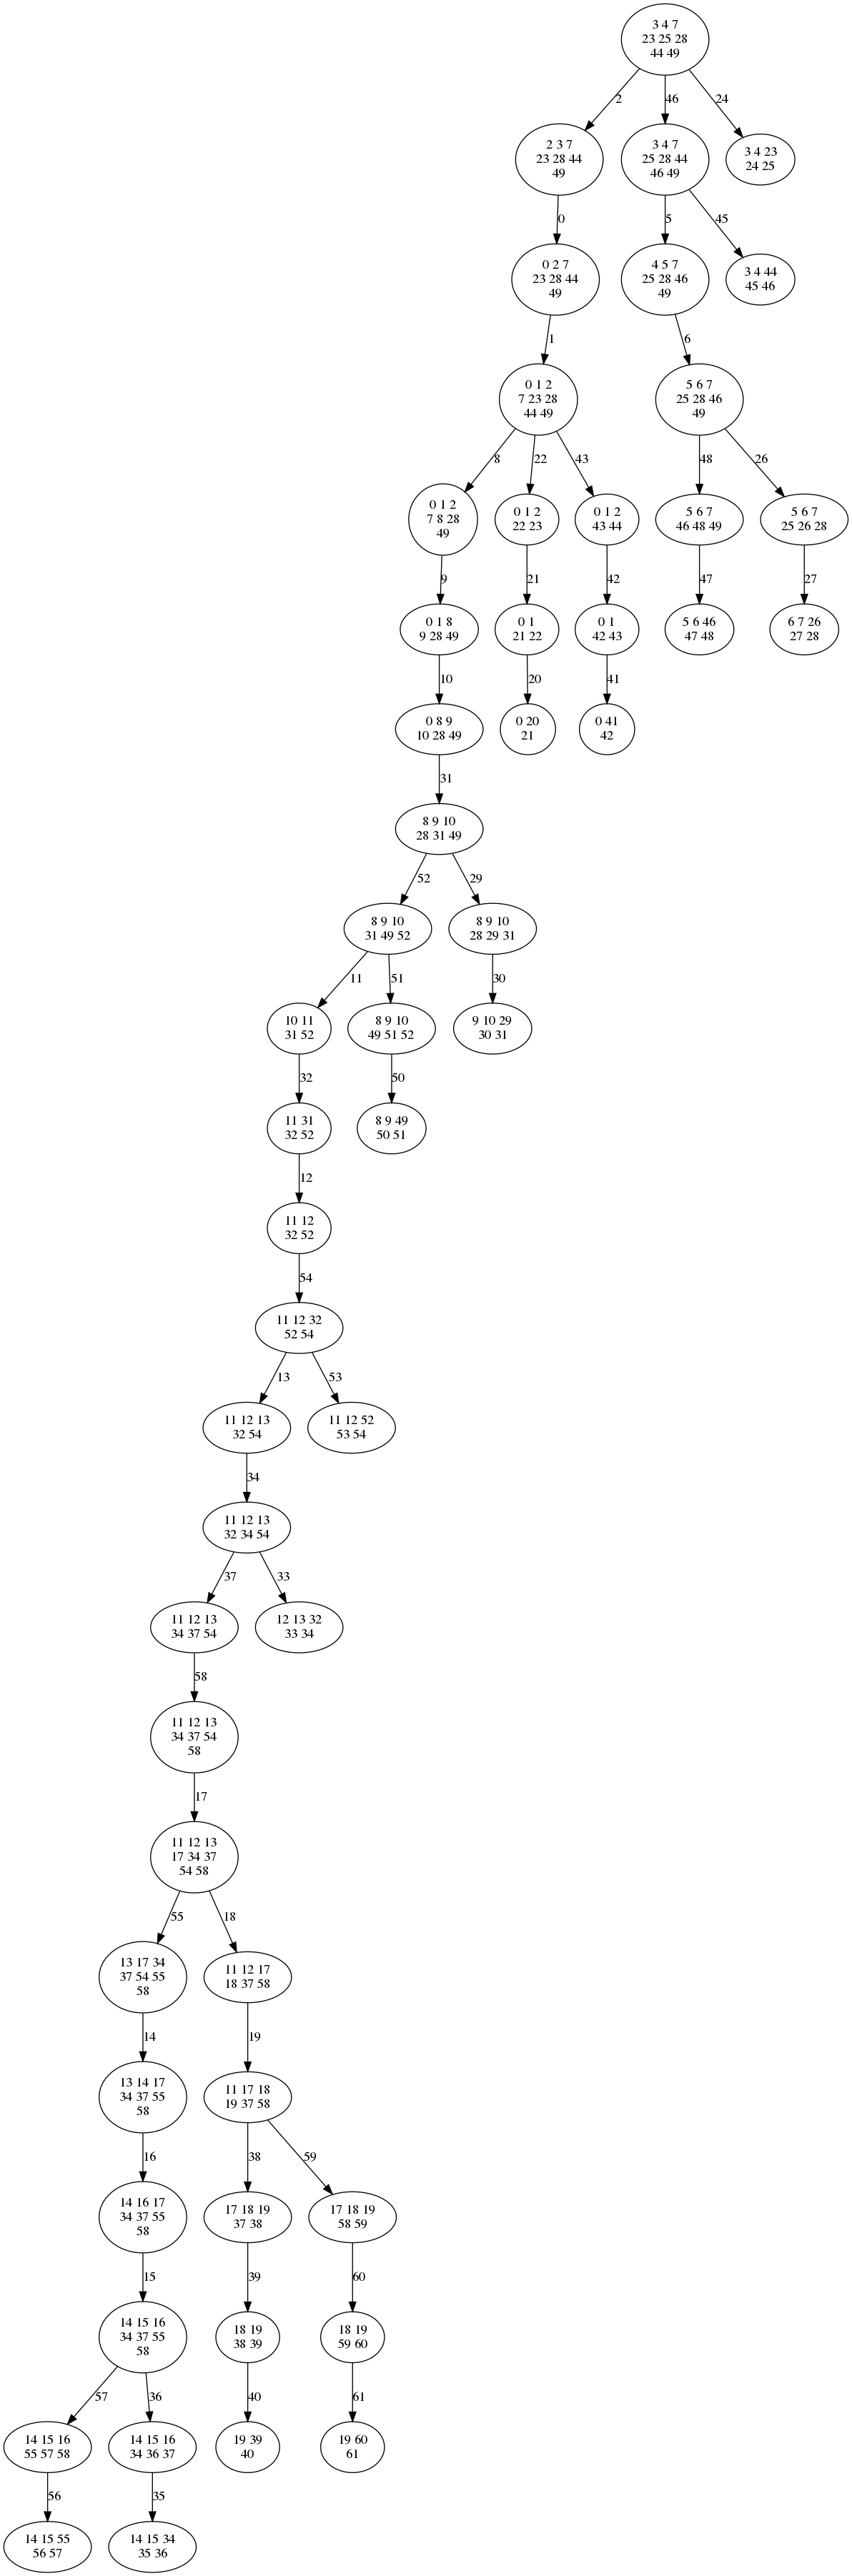

In [24]:
### Impose (AAA or UAA) and (CCC) in samples

variables = [4]*seqlen
states1, dfa_constraints1 = ir.words_to_accept(['AAA','UAA'], seqlen-1, seqlen, start=0)
states2, dfa_constraints2 = ir.words_to_accept(['CCC'], seqlen-1, seqlen+len(states1), start=0)

cn = ir.ConstraintNetwork(domains=variables + states1 + states2,
                          constraints = cons + gg_cons + dfa_constraints1 + dfa_constraints2,
                          functions = bpe_funs + gc_funs)
ct = ir.ClusterTree(cn)

print("  "+structure)
spit_them_samples_out(ct, 10, seqlen)

In [31]:
### Impose (UGAAAUGUAA) but avoid (CC) in the first half of sample

variables = [4]*seqlen
states1, dfa_constraints1 = ir.words_to_accept(['UGAAAUGUAA'], seqlen-1, seqlen, start=0)
states2, dfa_constraints2 = ir.words_to_avoid(['CC'], int(seqlen/2), seqlen+len(states1), start=0)

cn = ir.ConstraintNetwork(domains=variables + states1 + states2,
                          constraints = cons + gg_cons + dfa_constraints1 + dfa_constraints2,
                          functions = bpe_funs + gc_funs)
ct = ir.ClusterTree(cn)

print("  "+structure)
spit_them_samples_out(ct, 10, seqlen)

  ((((...))))(((...)))


['UUCGACAUGAAAUGUAACAU1881111186104790325555111211211111',
 'CAUUUGAAAUGUAAACCUUG1118886104790325555555121111111111',
 'UGUGAAAUGUAAGCCUAGCU1868610479032555555555111111111111',
 'ACGUGAAAUGUAAUGUAGUU1111861047903255555555112111111111',
 'GCAUGAAAUGUAAGCGACUU1111861047903255555555112111111111',
 'UGUGAAAUGUAACGAAACGU1868610479032555555555111111111111',
 'UAUGAAAUGUAAGUCAUGCU1818610479032555555555111111111111',
 'UGUGAAAUGUAAUGUAAUGU1868610479032555555555111111111111',
 'GCAUGAAAUGUAAUGUCGUU1111861047903255555555112111111111',
 'ACAUGAAAUGUAAACUCUUU1111861047903255555555112111111111']

tree width = 7
bags = [[44, 28, 7, 49, 4, 23, 25, 3], [2, 23, 44, 28, 7, 49, 3], [1, 23, 28, 44, 2, 7, 49], [1, 44, 2, 28, 7, 49, 0, 23], [44, 28, 7, 49, 4, 46, 25, 3], [1, 28, 8, 2, 7, 49, 0], [1, 8, 28, 10, 49, 0], [1, 9, 8, 28, 10, 49], [5, 4, 28, 7, 46, 25, 49], [5, 28, 7, 46, 25, 6, 49], [5, 27, 28, 7, 25, 6], [5, 7, 46, 47, 6, 49], [1, 44, 2, 43, 0], [1, 23, 2, 22, 0], [4, 23, 25, 24, 3], [29, 8, 28, 10, 9], [9, 50, 8, 10, 49], [5, 26, 27, 25, 6], [7, 48, 47, 6, 49], [4, 45, 44, 46, 3], [29, 10, 9, 30], [10, 31, 30], [10, 31, 11], [33, 31, 11], [33, 31, 12, 11], [33, 34, 12, 11], [33, 34, 12, 13, 11], [34, 12, 18, 13, 11], [34, 38, 18, 13, 11], [34, 17, 18, 13, 38], [34, 17, 37, 13, 38], [16, 37, 17, 34, 13], [16, 37, 34, 36, 13], [16, 34, 36, 13, 15], [34, 14, 36, 13, 15], [35, 34, 14, 36, 15], [32, 33, 12, 31, 11], [18, 19, 11, 38], [42, 1, 43, 0], [18, 39, 38, 19], [1, 22, 21, 0], [51, 9, 10, 50], [20, 21, 0], [42, 41, 0], [40, 39, 19], [51, 52, 10]]
edges = [(0, 1), (0, 4), (

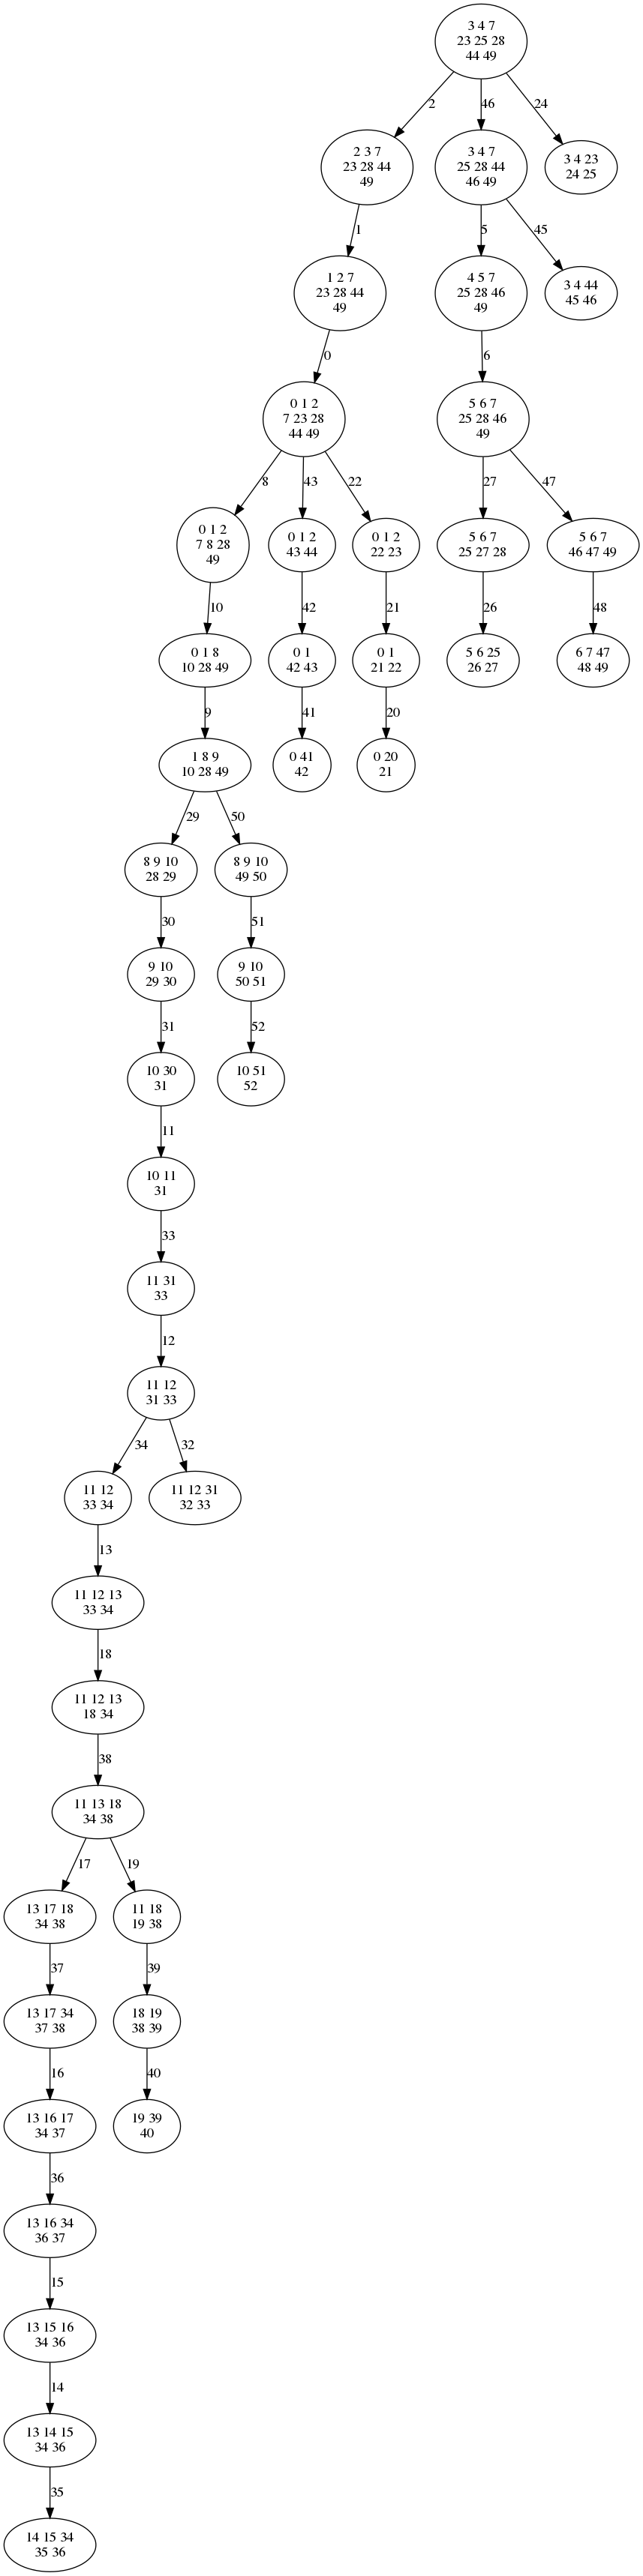

In [32]:
show_td_info(ct,500)

In [19]:
#### now, automatize the targeting of feature values
##

# -- we start by defining the features

class GCFeature(ir.Feature):
    def __init__(self, weight, target, tolerance):
        super().__init__( "GC", weight, target, tolerance)
    def eval(self, sample):
        return rna.GC_content(sample) * 100

class EnergyFeature(ir.Feature):
    def __init__(self, structure, weight, target, tolerance):
        super().__init__( "E", weight, target, tolerance )
        self.structure = structure
    def eval(self, sample):
        import RNA
        return RNA.energy_of_struct(sample, self.structure)

In [19]:
# -- next, instantiate the sampler

class MySampler(ir.MultiDimensionalBoltzmannSampler):
    def __init__( self, features ):
        super().__init__(features)
        
    def gen_constraint_network(self, features):
        bpe_weight = features["E"].weight
        bpe_funs = [ rna.BPEnergy( i = i , j = j,
                                   is_terminal = False,
                                   weight = bpe_weight ) 
                     for ( i, j ) in bps ] 
        gc_weight = features["GC"].weight
        gc_funs = [ GCControl( i = i, weight = gc_weight )
                    for i in range(seqlen) ]
        return ir.ConstraintNetwork( varnum = seqlen, domains = 4,
                                     constraints = cons,
                                     functions = bpe_funs + gc_funs )
    
    def sample(self):
        return rna.values_to_sequence(super().sample().values())
                  
# -- produce the feature objects 
# !!! here we define the targeted feature values and tolerances !!!
features = { "E": EnergyFeature(structure,1,-2,1),
             "GC": GCFeature(1,70,15) }

# -- from this, construct the sampler
sampler = MySampler(features)

In [23]:
# -- and sample away
count=0
for seq in sampler.targeted_samples():
    import RNA # for energy evaluation
    print("{} {:.2f} {:.2f}".format(seq, RNA.energy_of_struct(seq,structure), 100*rna.GC_content(seq)))
    count+=1
    if count >= 10:
        break

ImportError: cannot import name '_RNA' from partially initialized module 'RNA' (most likely due to a circular import) (/usr/local/lib/python3.6/site-packages/RNA/__init__.py)